In [1]:
import os
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import pandas as pd
from lsst.sims.photUtils import Bandpass
import lsst.syseng.throughputs as st

In [2]:
defaultDirs = st.setDefaultDirs()
defaultDirs

{'detector': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/detector/joint_minimum',
 'lens1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens1',
 'lens2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens2',
 'lens3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/lens3',
 'filters': '/Users/lynnej/lsstRepos/syseng_throughputs/components/camera/filters',
 'mirror1': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror1',
 'mirror2': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror2',
 'mirror3': '/Users/lynnej/lsstRepos/syseng_throughputs/components/telescope/mirror3',
 'atmosphere': '/Users/lynnej/lsstRepos/syseng_throughputs/siteProperties'}

In [3]:
# Read the non-mirror components
detector = st.buildDetector(defaultDirs['detector'])
lens1 = st.buildLens(defaultDirs['lens1'])
lens2 = st.buildLens(defaultDirs['lens2'])
lens3 = st.buildLens(defaultDirs['lens3'])
filters = st.buildFilters(defaultDirs['filters'])
atmos = st.readAtmosphere(defaultDirs['atmosphere'])

In [4]:
# We need a silver mirror and an aluminum mirror
os.listdir(defaultDirs['mirror1']), os.listdir(defaultDirs['mirror2']), os.listdir(defaultDirs['mirror3'])

(['m1_ProtAl_Ideal.dat', 'm1_Losses'],
 ['m2_Losses', 'm2_ProtAg_Ideal.dat'],
 ['m3_Losses', 'm3_ProtAl_Ideal.dat'])

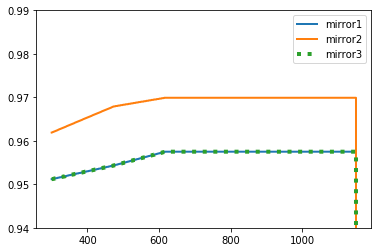

In [5]:
# check if mirror losses are the same ..
losses = {}
for m in ('mirror1', 'mirror2', 'mirror3'):
    losses[m] = Bandpass()
    losses[m].readThroughput(os.path.join(defaultDirs[m], '%s%s_Losses' % (m[0],m[-1]), 
                                          '%s%s_Losses.dat' % (m[0], m[-1])))
    linestyle = '-'
    width=2
    if m == 'mirror3':
        linestyle=':'
        width=4
    plt.plot(losses[m].wavelen, losses[m].sb, linestyle=linestyle, linewidth=width, label=m)
plt.ylim(0.94, 0.99)
plt.legend()

In [6]:
# Mirror losses are not the same (up vs. down-facing I think), so turn them off for now.
mirror = {}
mirror['Al'] = st.buildMirror(defaultDirs['mirror1'], addLosses=False)
mirror['Ag'] = st.buildMirror(defaultDirs['mirror2'], addLosses=False)
# BUT because they are not material dependent and just multiply by the mirror throughput .. 
# we can add them back anyway



In [7]:
# Ok .. 8 combos are actually 4 because it doesn't matter which order the mirrors are in.
combos = [['Al', 'Al', 'Al'], ['Al', 'Ag', 'Al'], ['Ag', 'Al', 'Ag'], ['Ag', 'Ag', 'Ag']]

m5 = {}
system_all = {}
for combo in combos:
    hardware = {}
    system = {}
    for f in filters:
        wavelen = detector.wavelen
        # Hardware
        sb = detector.sb * lens1.sb * lens2.sb * lens3.sb * filters[f].sb
        sb *= losses['mirror1'].sb * losses['mirror2'].sb * losses['mirror3'].sb
        sb *= mirror[combo[0]].sb * mirror[combo[1]].sb * mirror[combo[2]].sb
        hardware[f] = Bandpass()
        hardware[f].setBandpass(wavelen, sb)
        system[f] = Bandpass()
        system[f].setBandpass(wavelen, sb * atmos.sb)
    system_all['-'.join(combo)] = system
    m5['-'.join(combo)] = st.makeM5(hardware, system)

In [8]:
from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4),
                Line2D([0], [0], color='k', lw=4)]

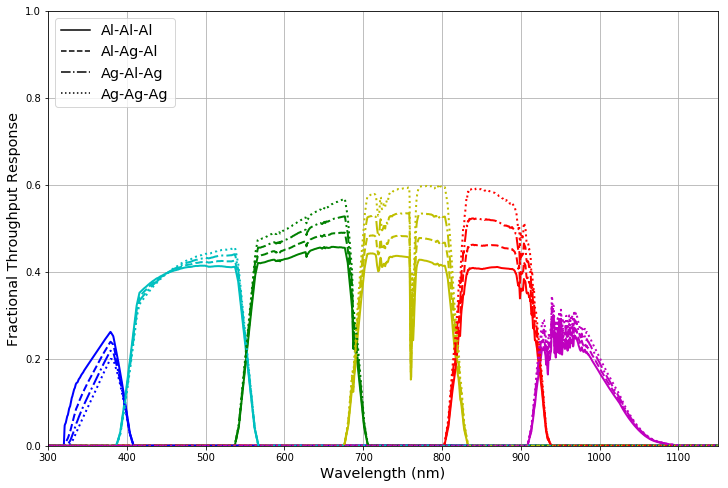

In [9]:
plt.figure(figsize=(12, 8))
linestyles = ['-', '--', '-.', ':']
leg_elements = []
for i, combo in enumerate(combos):
    label = '-'.join(combo)
    linestyle= linestyles[i]
    st.plotBandpasses(system_all['-'.join(combo)], newfig=False, addlegend=False, linestyle=linestyle)
    leg_elements.append(Line2D([0], [0], color='k', linestyle=linestyle, label=label))
plt.legend(handles=leg_elements, loc='upper left', fontsize='x-large', fancybox=True)

In [10]:
d = pd.DataFrame({'Al-Al-Al': m5['Al-Al-Al'].m5, 'Al-Ag-Al': m5['Al-Ag-Al'].m5,
                  'Ag-Al-Ag': m5['Ag-Al-Ag'].m5, 'Ag-Ag-Ag': m5['Ag-Ag-Ag'].m5})
d

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag
u,23.924455,23.745309,23.588672,23.445098
g,24.821169,24.824830,24.828832,24.833170
r,24.338847,24.373384,24.407785,24.442057
i,23.879893,23.941583,24.002685,24.063250
z,23.292193,23.360531,23.428425,23.495914
y,22.413444,22.453891,22.494213,22.534419


In [11]:
delta_m5 = d.T - d['Al-Ag-Al'].T
delta_m5.T
# Positive values mean deeper limiting magnitudes

,Al-Al-Al,Al-Ag-Al,Ag-Al-Ag,Ag-Ag-Ag
u,0.179146,0.0,-0.156637,-0.300211
g,-0.003660,0.0,0.004002,0.008341
r,-0.034537,0.0,0.034401,0.068672
i,-0.061690,0.0,0.061102,0.121667
z,-0.068338,0.0,0.067894,0.135383
y,-0.040448,0.0,0.040322,0.080528
